## Vector quantization

Most vector embeddings are stored as floating point numbers (64-bit in Python). We can use **quantization** to reduce the size of the embeddings.

In [13]:
# Load in the vectors from movies.json, {movie: [vector]}
import json

with open('openai_movies.json') as f:
    movies = json.load(f)

In [14]:
# Quantize all the vectors to 1 byte
import numpy as np


def quantize_vector(vec):
    """Turn a float64 into a int8"""
    vec = np.array(vec) + 1
    vec = np.clip(vec, 0, 2)
    vec = vec * 127
    vec = vec.astype(np.uint8)
    return vec

movies_1byte = {k: quantize_vector(v) for k, v in movies.items()}
for k, v in list(movies_1byte.items())[:10]:
    print(k, v)

Snow White and the Seven Dwarfs [124 122 124 ... 128 126 123]
Pinocchio [125 125 129 ... 130 127 124]
Fantasia [128 125 127 ... 126 127 123]
Song of the South [123 123 125 ... 125 127 126]
Cinderella [126 123 126 ... 127 126 127]
20,000 Leagues Under the Sea [128 124 129 ... 124 126 122]
Lady and the Tramp [123 125 126 ... 126 127 123]
Sleeping Beauty [125 124 127 ... 130 126 125]
101 Dalmatians [126 126 124 ... 126 125 124]
The Absent Minded Professor [124 127 127 ... 124 126 123]


In [15]:
# 10 most similar movies to Moana
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(movie, movies):
    movie_vec = movies[movie]
    similarities = {k: cosine_similarity([movie_vec], [v])[0][0] for k, v in movies.items()}
    closest = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(closest, columns=['movie', 'similarity'])
    return df

most_similar('Moana', movies_1byte)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.999933
2,The Little Mermaid,0.999914
3,Pocahontas,0.999905
4,Aladdin,0.999905
5,Tangled,0.999904
6,Hannah Montana the Movie,0.999903
7,Lilo & Stitch,0.999903
8,Cinderella,0.999902
9,Maleficent,0.999900


In [16]:
most_similar('Moana', movies)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.905926
2,The Little Mermaid,0.877542
3,Aladdin,0.864455
4,Pocahontas,0.862812
5,Hannah Montana the Movie,0.860928
6,Lilo & Stitch,0.858802
7,Cinderella,0.858162
8,Tangled,0.858131
9,Maleficent,0.856232


## Binary quantization

The most extreme form of quantization is to store the embeddings as binary numbers, setting each dimension to 0 or 1, based on a threshold.

In [17]:
def quantize_vector(vec, threshold):
    """Turn a float32 into a bit by thresholding at 0"""
    vec = np.array(vec)
    vec = (vec > threshold).astype(np.int8)
    return vec

# calculate the mean of all the dimensions of each vector
mean_vec = np.mean(np.mean(list(movies.values()), axis=0))

movies_1bit = {k: quantize_vector(v, mean_vec) for k, v in movies.items()}
for k, v in list(movies_1bit.items())[:10]:
    print(k, v)

Snow White and the Seven Dwarfs [0 0 0 ... 1 0 0]
Pinocchio [0 0 1 ... 1 1 0]
Fantasia [1 0 1 ... 0 1 0]
Song of the South [0 0 0 ... 0 1 0]
Cinderella [0 0 0 ... 1 0 1]
20,000 Leagues Under the Sea [1 0 1 ... 0 0 0]
Lady and the Tramp [0 0 1 ... 0 1 0]
Sleeping Beauty [0 0 1 ... 1 1 0]
101 Dalmatians [0 0 0 ... 0 0 0]
The Absent Minded Professor [0 1 1 ... 0 0 0]


In [18]:
most_similar('Moana', movies_1bit)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.797453
2,Lilo & Stitch,0.766315
3,The Little Mermaid,0.762547
4,Hannah Montana the Movie,0.761729
5,Pocahontas,0.754125
6,Big Hero 6,0.754006
7,Disney Planes,0.746025
8,Tangled,0.745110
9,Finding Nemo,0.742330


## Visualizing the quantization

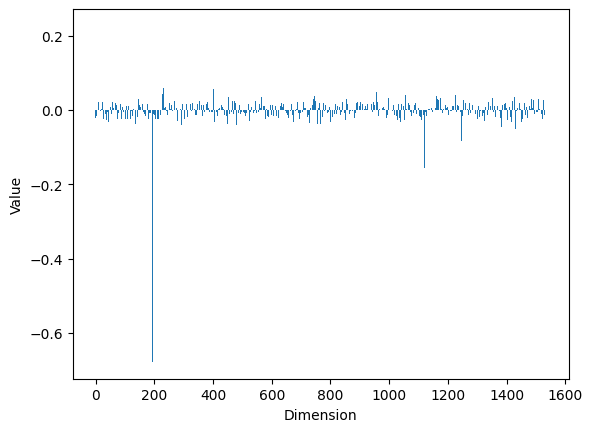

In [19]:
# make a chart of a single vector
import matplotlib.pyplot as plt

vector = movies['Moana']
plt.bar(range(len(vector)), vector)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.show()

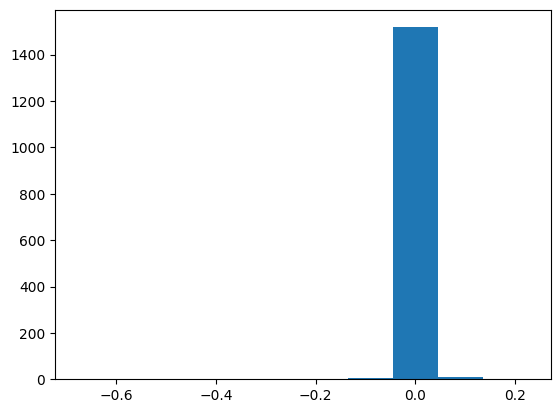

In [20]:
# make a histogram of a single vector
plt.hist(movies['Moana'])
plt.show()

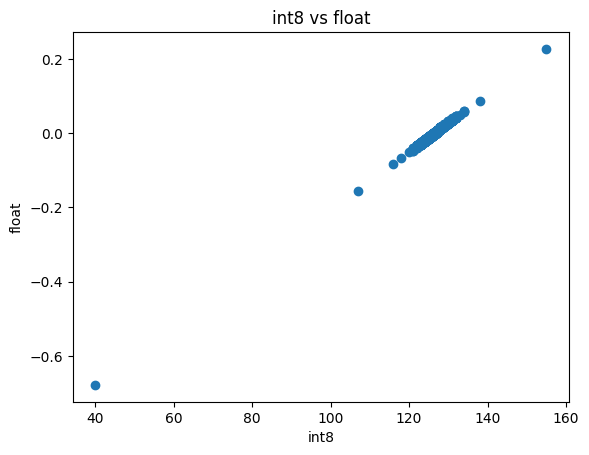

In [21]:
# Compare the 1bit and 1byte vectors in a 2d plot
plt.scatter(movies_1byte['Moana'], movies['Moana'])
plt.xlabel('int8')
plt.ylabel('float')
plt.title('int8 vs float')
plt.show()

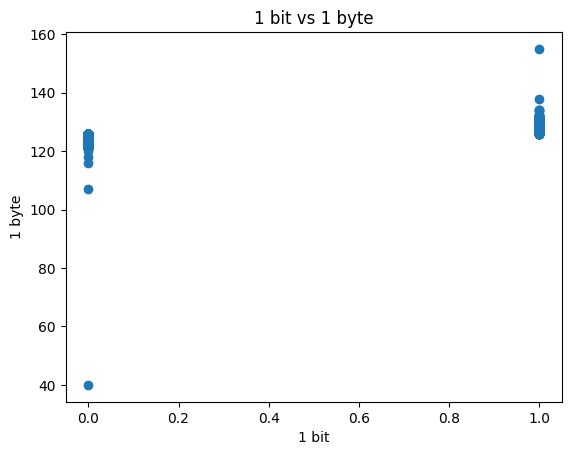

In [22]:
# Compare the 1bit and 1byte vectors in a 2d plot
plt.scatter(movies_1bit['Moana'], movies_1byte['Moana'])
plt.xlabel('1 bit')
plt.ylabel('1 byte')
plt.title('1 bit vs 1 byte')
plt.show()

## Size comparison

In [23]:
import sys

pd.DataFrame({
    'float64': [sys.getsizeof(movies['Moana'])],
    'int8': [sys.getsizeof(movies_1byte['Moana'])],
    'int1': [sys.getsizeof(movies_1bit['Moana'])],
})

,float64,int8,int1
0,12728,1648,1648


In [24]:
sys.getsizeof(movies['Moana'])/sys.getsizeof(movies_1byte['Moana'])

7.723300970873787

## Resources

* [Scalar quantization 101](https://www.elastic.co/search-labs/blog/scalar-quantization-101)
* [Product quantization 101](https://www.pinecone.io/learn/series/faiss/product-quantization/)
* [Binary and scalar quantization](https://huggingface.co/blog/embedding-quantization)